In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy


from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

import pymorphy3
import re

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


from keras.layers import LSTM, Embedding, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import Sequential
from keras.models import save_model, load_model

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
def remove_stopwords(text, stoplist):
    return [word for word in text if word not in stoplist]


def remove_punctuation(text):
    punctuation = string.punctuation
    return ''.join([c if c not in punctuation else ' ' for c in text])


def remove_spaces(text):
    return re.sub(r'\s+', ' ', text)


def clean_text(data):
    cleaned_text = [remove_punctuation(remove_spaces(str(text).lower())) for text in data['text']]
    data['text'] = cleaned_text
    return data

In [3]:
def lemmatize_text(data):
    min_length = 2
    stoplist = stopwords.words("russian")
    morph = pymorphy3.MorphAnalyzer(lang='ru')  # 'fix'
    lemmatized_text = []
    for text in data['text']:
        text_lem = [morph.parse(word)[0].normal_form for word in text.split(' ')]
        text_lem = remove_stopwords(text_lem, stoplist)

    if len(text_lem) > min_length:
        lemmatized_text.append(' '.join(text_lem))
    else:
        lemmatized_text.append('')
    data['text'] = lemmatized_text
    return data

def tokenize_text(data, max_article_length):
    num_words = 10000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(data['text'])
    x = tokenizer.texts_to_sequences(data['text'])
    x = pad_sequences(x, maxlen=max_article_length)
    return x

In [4]:
def print_history(history):
    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

    fig.add_subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training loss', 'Validation loss'])
    plt.title('Training and validation loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()

In [24]:
class ModelUsage:
    def __init__(self):
        self.num_words = 10000
        self.max_article_length = 750

    def model_create_image_13(self):
        #
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        #model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(13, activation='sigmoid'))
        return model

    
    def model_create_image_52(self):
        #
        model = Sequential()
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
        #model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='sigmoid'))
        model.add(Dense(52, activation='sigmoid'))
        return model

    def model_create_text(self):
        #
        model = Sequential()
        model.add(Embedding(input_dim=self.num_words, output_dim=64, input_length=self.max_article_length))
        model.add(LSTM(units=64))
        model.add(Dense(5, activation='sigmoid'))
        return model
    

    def model_create_text_2(self):
        #
        model = Sequential()
        model.add(Embedding(input_dim=self.num_words, output_dim=64, input_length=self.max_article_length))
        model.add(LSTM(units=64, return_sequences=True))
        model.add(LSTM(units=64))
        model.add(Dense(5, activation='sigmoid'))
        return model

    def model_create_drink(self):
        #
        model = Sequential()
        model.add(Dense(32, input_dim=3,  activation='sigmoid'))
        model.add(Dense(128,  activation='sigmoid'))
        model.add(Dense(6, activation='sigmoid'))
        return model

    def model_compile(self, model):
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    def model_save(self, model, job, path):
        model.save(path + job + 'model.h5')

    def model_load(self, job, path):
        model = load_model(path + job + 'model.h5')
        return model

    def model_train(self, model, train_x, train_y, ep):
        history = model.fit(train_x, train_y, epochs=ep, validation_split=0.2)
        fig = plt.figure(figsize=(15,4))
        print_history(history)

    def model_train_im52(self, model, train_x, train_y, ep, callbacks):
        history = model.fit(train_x, train_y, epochs=ep,  callbacks=callbacks,  validation_split=0.3)
        fig = plt.figure(figsize=(15,4))
        print_history(history)

    def model_evaluate(self, model, test_x, test_y):
        results = model.evaluate(test_x, test_y)
        print(results)


In [25]:
m = ModelUsage()
path = "saved_model\\"

In [7]:
def load_classification_data(): #создача фрейма
    df = pd.read_csv("caffeine.csv")
    df.isnull().any()
    return(df)

In [8]:
def save_preprocessed_data(df):
    filename = "lenta-ru-clean-20k.csv"
    df.to_csv(filename)

In [9]:
def load_unprocessed_text_to_df():
    filename = "lenta-ru-train.csv"
    data = pd.read_csv(filename, index_col=False, encoding="utf8", nrows=20000)
    df = pd.DataFrame(data)
    df['text'] = df['title'].str.ljust(1) + df['text']
    df = df.drop(['topic', 'title'], axis=1)
    return df


In [10]:
def load_processed_text_to_df():
    filename = "lenta-ru-clean-20k.csv"
    data = pd.read_csv(filename, index_col=False, encoding="utf8", nrows=20000)
    df = pd.DataFrame(data) 
    return df

In [11]:
def load_image_data(): 
    filename = "playing cards.csv"
    data = pd.read_csv(filename, index_col=False, encoding="utf8")
    df = pd.DataFrame(data) 
    return df

In [12]:
def image_features(paths):
    x = []
    for path in paths:
        image = io.imread(path)
        #image_res = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
        #                               anti_aliasing=True)
        image_res = resize(image,  (150, 150), anti_aliasing=True)
        np_pic = np.array(image_res, dtype=np.float32)/255
        x.append(np_pic)
    return x

1. Drink classification

In [19]:
df = load_classification_data()
#removing missing values
df.dropna(inplace=True)

df.head()

drink  Volume (ml)  Calories  Caffeine (mg)    type
0                 Costa Coffee   256.993715         0            277  Coffee
1  Coffee Friend Brewed Coffee   250.191810         0            145  Coffee
2           Hell Energy Coffee   250.191810       150            100  Coffee
3           Killer Coffee (AU)   250.191810         0            430  Coffee
4                 Nescafe Gold   250.191810         0             66  Coffee

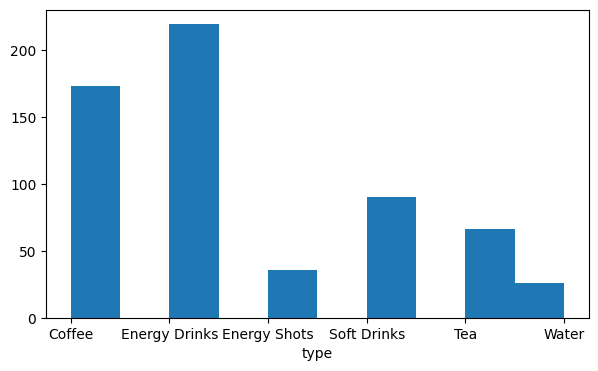

In [20]:
plt.figure(figsize=(7,4))
plt.hist(df[df.columns[4]])
plt.xlabel(df.columns[4])
plt.show()

['Coffee' 'Energy Drinks' 'Energy Shots' 'Soft Drinks' 'Tea' 'Water']
[0 1 2 3 4 5]
               Volume (ml)  Calories  Caffeine (mg)      type
Volume (ml)       1.000000  0.341998       0.110770  0.005839
Calories          0.341998  1.000000      -0.126021 -0.075057
Caffeine (mg)     0.110770 -0.126021       1.000000 -0.361060
type              0.005839 -0.075057      -0.361060  1.000000


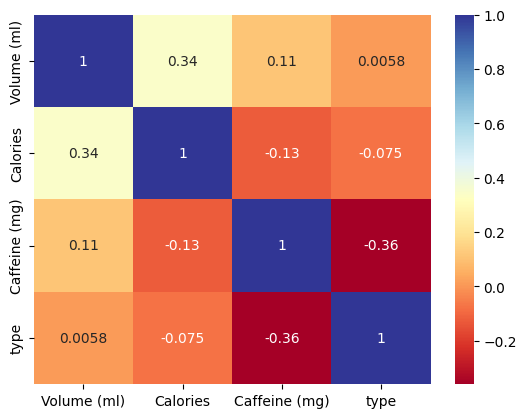

In [21]:
label_encoder = LabelEncoder()
df2 = copy.deepcopy(df)
categories = ["type"]
for category in categories:
    print(df2[category].unique())
    df2[category]=label_encoder.fit_transform(df2[category])
    print(df2[category].unique())
    
print(df2.corr())

dataplot = sns.heatmap(df2.corr(), cmap="RdYlBu", annot=True)
#cmap="RdYlBu"
plt.show()

In [22]:
df3 = df2.drop('drink', axis=1)
names = df3.columns
df_n = preprocessing.normalize(df3, axis=0)
df_r = pd.DataFrame(df_n, columns=names)
#x = df_r.drop('type', axis=1)
x = df3.drop('type', axis=1)
#Нормалізація значно знижує точність
y = df2['type']

In [36]:
drink_model = m.model_create_drink()
m.model_compile(drink_model)
drink_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                128       
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 5,126
Trainable params: 5,126
Non-trainable params: 0
_________________________________________________________________


In [37]:
#drink_model = m.model_load("drink", "saved_model\\")

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.5, random_state = 0)

Epoch 1/30
8/8 [==============================] - 1s 33ms/step - loss: 1.7066 - accuracy: 0.3607 - val_loss: 1.6091 - val_accuracy: 0.3115
Epoch 2/30
8/8 [==============================] - 0s 8ms/step - loss: 1.5493 - accuracy: 0.3607 - val_loss: 1.5153 - val_accuracy: 0.3443
Epoch 3/30
8/8 [==============================] - 0s 8ms/step - loss: 1.5197 - accuracy: 0.4016 - val_loss: 1.4824 - val_accuracy: 0.4590
Epoch 4/30
8/8 [==============================] - 0s 7ms/step - loss: 1.5030 - accuracy: 0.3975 - val_loss: 1.4585 - val_accuracy: 0.4754
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: 1.4799 - accuracy: 0.4057 - val_loss: 1.4446 - val_accuracy: 0.3770
Epoch 6/30
8/8 [==============================] - 0s 7ms/step - loss: 1.4637 - accuracy: 0.3770 - val_loss: 1.4367 - val_accuracy: 0.3115
Epoch 7/30
8/8 [==============================] - 0s 8ms/step - loss: 1.4377 - accuracy: 0.3770 - val_loss: 1.4067 - val_accuracy: 0.3934
Epoch 8/30
8/8 [=================

<Figure size 1500x400 with 0 Axes>

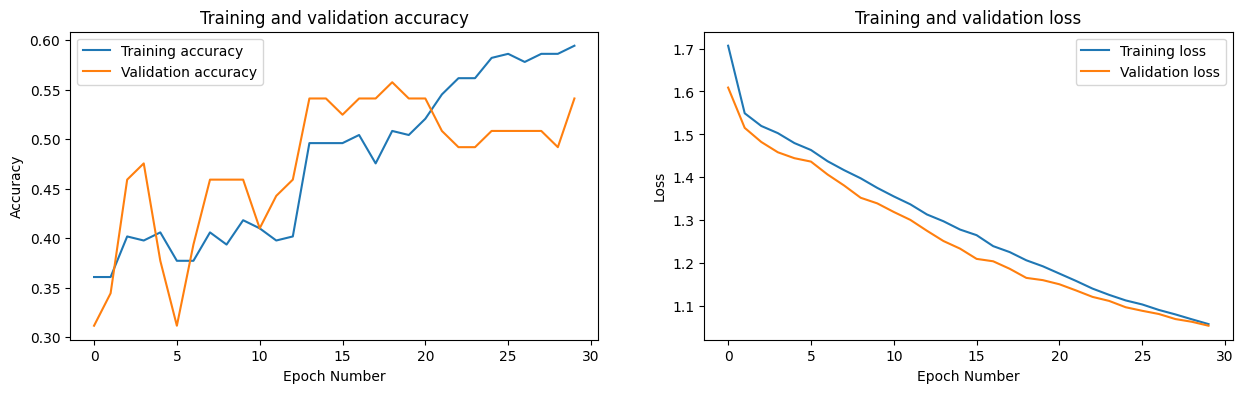

In [39]:
m.model_train(drink_model, X_train, Y_train, 30)

In [40]:
m.model_evaluate(drink_model, X_test, Y_test)

10/10 [==============================] - 0s 3ms/step - loss: 1.0316 - accuracy: 0.6000
[1.0315983295440674, 0.6000000238418579]


2. Image classification

In [13]:
image_set = load_image_data()
image_set.head()
#індекси в першій колонці - то для класифікації з 52 класів

class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train

In [14]:
image_set_labels = image_set.drop_duplicates(subset = ["labels"])
image_set_labels = image_set_labels.reset_index()

image_set_labels


index  class index                        filepaths             labels  \
0       0            0       train/ace of clubs/001.jpg       ace of clubs   
1     120            1    train/ace of diamonds/001.jpg    ace of diamonds   
2     249            2      train/ace of hearts/001.jpg      ace of hearts   
3     420            3      train/ace of spades/001.jpg      ace of spades   
4     601            4     train/eight of clubs/001.jpg     eight of clubs   
5     739            5  train/eight of diamonds/001.jpg  eight of diamonds   
6     898            6    train/eight of hearts/001.jpg    eight of hearts   
7    1050            7    train/eight of spades/001.jpg    eight of spades   
8    1185            8      train/five of clubs/001.jpg      five of clubs   
9    1335            9   train/five of diamonds/001.jpg   five of diamonds   
10   1473           10     train/five of hearts/001.jpg     five of hearts   
11   1609           11     train/five of spades/001.jpg     five of spades   
12   1767           12      train/four of clubs/001.jpg      four of clubs   
13   1924           13   train/four of diamonds/001.jpg   four of diamonds   
14   2038           14     train/four of hearts/001.jpg     four of hearts   
15   2192           15     train/four of spades/001.jpg     four of spades   
16   2332           16      train/jack of clubs/001.jpg      jack of clubs   
17   2503           17   train/jack of diamonds/001.jpg   jack of diamonds   
18   2663           18     train/jack of hearts/001.jpg     jack of hearts   
19   2831           19     train/jack of spades/001.jpg     jack of spades   
20   3003           20      train/king of clubs/001.jpg      king of clubs   
21   3131           21   train/king of diamonds/001.jpg   king of diamonds   
22   3266           22     train/king of hearts/001.jpg     king of hearts   
23   3391           23     train/king of spades/001.jpg     king of spades   
24   3542           24      train/nine of clubs/001.jpg      nine of clubs   
25   3666           25   train/nine of diamonds/001.jpg   nine of diamonds   
26   3795           26     train/nine of hearts/001.jpg     nine of hearts   
27   3928           27     train/nine of spades/001.jpg     nine of spades   
28   4082           28     train/queen of clubs/001.jpg     queen of clubs   
29   4243           29  train/queen of diamonds/001.jpg  queen of diamonds   
30   4406           30    train/queen of hearts/001.jpg    queen of hearts   
31   4545           31    train/queen of spades/001.jpg    queen of spades   
32   4707           32     train/seven of clubs/001.jpg     seven of clubs   
33   4815           33  train/seven of diamonds/001.jpg  seven of diamonds   
34   4939           34    train/seven of hearts/001.jpg    seven of hearts   
35   5082           35    train/seven of spades/001.jpg    seven of spades   
36   5247           36       train/six of clubs/001.jpg       six of clubs   
37   5399           37    train/six of diamonds/001.jpg    six of diamonds   
38   5538           38      train/six of hearts/001.jpg      six of hearts   
39   5665           39      train/six of spades/001.jpg      six of spades   
40   5823           40       train/ten of clubs/001.jpg       ten of clubs   
41   5964           41    train/ten of diamonds/001.jpg    ten of diamonds   
42   6115           42      train/ten of hearts/001.jpg      ten of hearts   
43   6244           43      train/ten of spades/001.jpg      ten of spades   
44   6402           44     train/three of clubs/001.jpg     three of clubs   
45   6528           45  train/three of diamonds/001.jpg  three of diamonds   
46   6681           46    train/three of hearts/001.jpg    three of hearts   
47   6794           47    train/three of spades/001.jpg    three of spades   
48   6936           48       train/two of clubs/001.jpg       two of clubs   
49   7066           49    train/two of diamonds/001.jpg    two of diamonds   
50   7199           50    

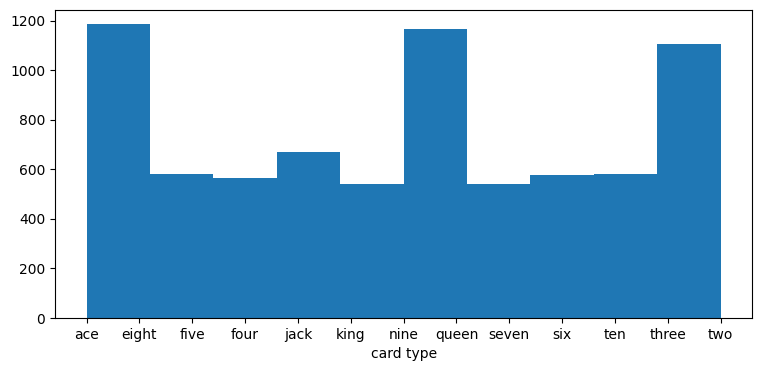

In [15]:
hist = image_set[image_set["data set"]=="train"]
plt.figure(figsize=(9,4))
plt.hist(hist[hist.columns[3]])
plt.xlabel(hist.columns[3])
plt.show()

In [16]:
label_encoder = LabelEncoder()
df2 = copy.deepcopy(image_set)
categories = ["card type"]
for category in categories:
    print(df2[category].unique())
    df2[category]=label_encoder.fit_transform(df2[category])
    print(df2[category].unique())
    
df2

['ace' 'eight' 'five' 'four' 'jack' 'king' 'nine' 'queen' 'seven' 'six'
 'ten' 'three' 'two']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


class index                   filepaths         labels  card type  \
0               0  train/ace of clubs/001.jpg   ace of clubs          0   
1               0  train/ace of clubs/002.jpg   ace of clubs          0   
2               0  train/ace of clubs/003.jpg   ace of clubs          0   
3               0  train/ace of clubs/004.jpg   ace of clubs          0   
4               0  train/ace of clubs/005.jpg   ace of clubs          0   
...           ...                         ...            ...        ...   
8024           51   valid/two of spades/1.jpg  two of spades         12   
8025           51   valid/two of spades/2.jpg  two of spades         12   
8026           51   valid/two of spades/3.jpg  two of spades         12   
8027           51   valid/two of spades/4.jpg  two of spades         12   
8028           51   valid/two of spades/5.jpg  two of spades         12   

     data set  
0       train  
1       train  
2       train  
3       train  
4       train  
...       ...  
8024    valid  
8025    valid  
8026    valid  
8027    valid  
8028    valid  

[8029 rows x 5 columns]

In [134]:
show_set = image_set_labels["filepaths"]
show_im = image_features(show_set)

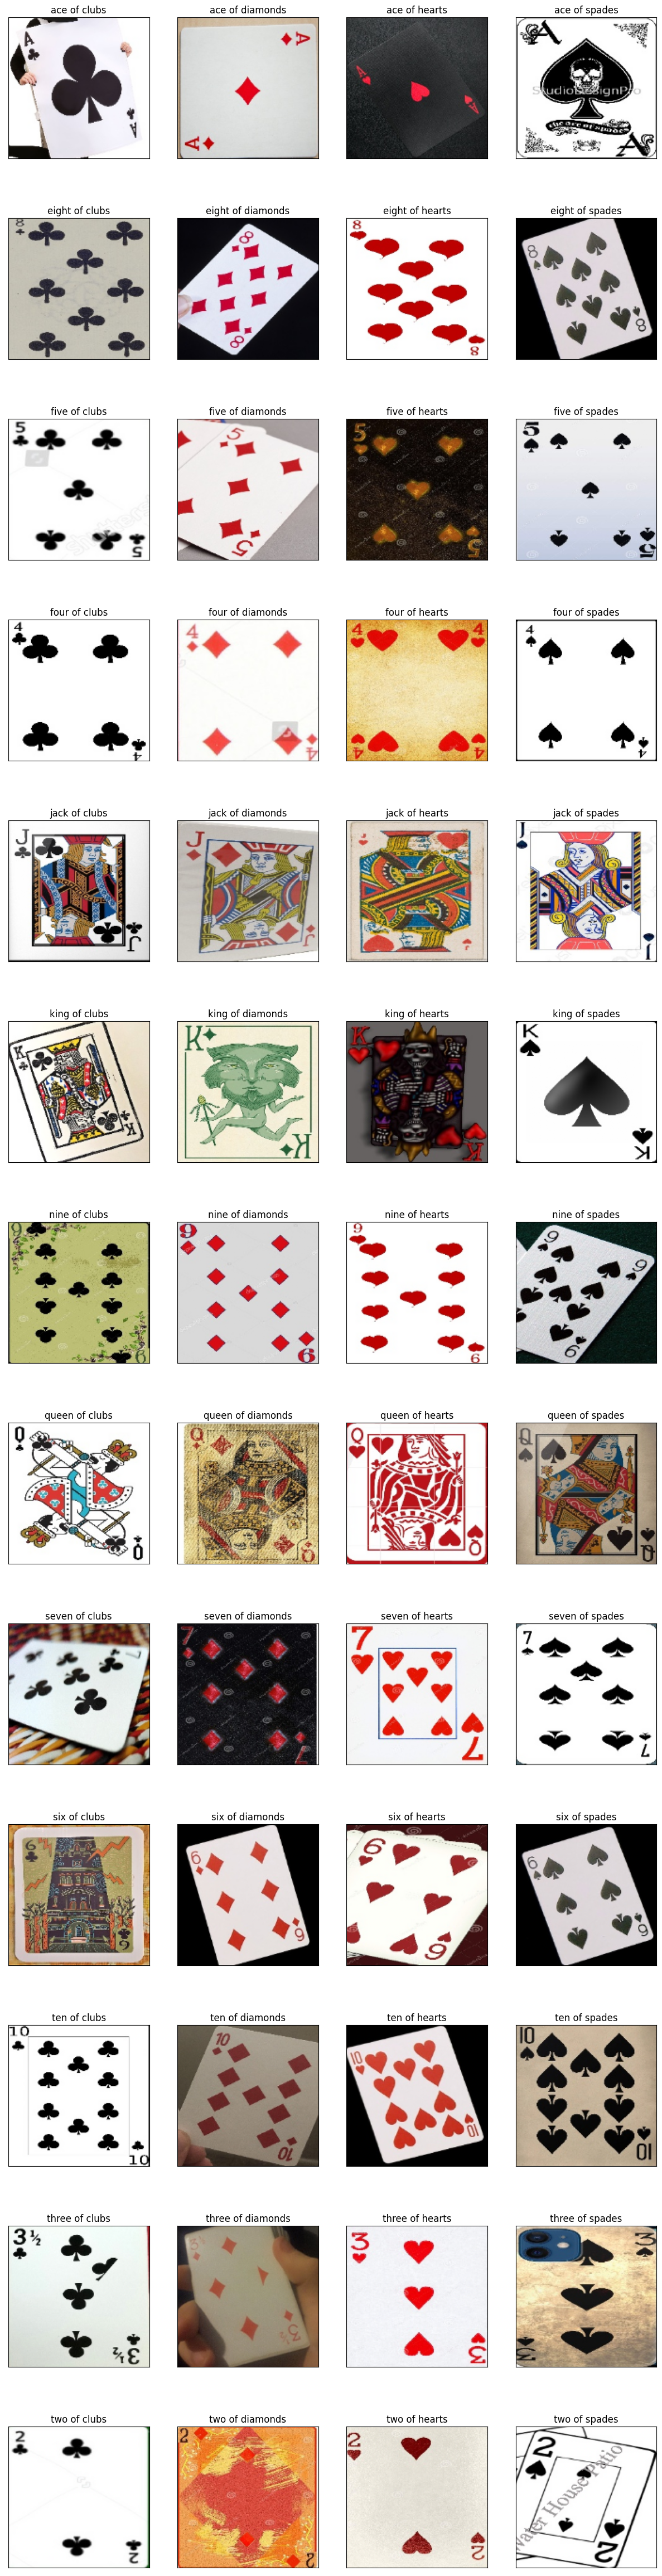

In [135]:

card_names = image_set_labels["labels"]
fig = plt.figure(figsize=(15,60))
rows = int(len(image_set_labels)/4)
for row in range(rows):
    for column in range(4):
        i = row * 4 + column
        if i>len(image_set_labels)-1:
            break                   
        ax = fig.add_subplot(rows, 4, i+1)
        ax.set_title(card_names[i])     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(show_im[i]*255)

13 classes

In [17]:
Y_train = df2[df2["data set"]=="train"]
X_train = Y_train["filepaths"]
Y_train = Y_train["card type"]

In [33]:
Y_test = df2[df2["data set"]=="test"]
X_test = Y_test["filepaths"]
Y_test = Y_test["card type"]

In [19]:
image_model_13 = m.model_create_image_13()
m.model_compile(image_model_13)
image_model_13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 32)       0

In [20]:
X_train = image_features(X_train)

In [21]:
#X_train = pd.Series(X_train)
X_train=np.asarray(X_train).astype(np.float32)
Y_train=np.asarray(Y_train).astype(np.int32)

Epoch 1/15
188/188 [==============================] - 231s 1s/step - loss: 2.0049 - accuracy: 0.3226 - val_loss: 5.0897 - val_accuracy: 0.1458
Epoch 2/15
188/188 [==============================] - 229s 1s/step - loss: 1.2731 - accuracy: 0.6171 - val_loss: 5.6502 - val_accuracy: 0.1578
Epoch 3/15
188/188 [==============================] - 222s 1s/step - loss: 1.1079 - accuracy: 0.6664 - val_loss: 6.0159 - val_accuracy: 0.1698
Epoch 4/15
188/188 [==============================] - 223s 1s/step - loss: 0.9997 - accuracy: 0.6977 - val_loss: 6.3744 - val_accuracy: 0.1638
Epoch 5/15
188/188 [==============================] - 216s 1s/step - loss: 0.9196 - accuracy: 0.7160 - val_loss: 6.7586 - val_accuracy: 0.1644
Epoch 6/15
188/188 [==============================] - 216s 1s/step - loss: 0.8475 - accuracy: 0.7363 - val_loss: 6.8404 - val_accuracy: 0.1644
Epoch 7/15
188/188 [==============================] - 222s 1s/step - loss: 0.7683 - accuracy: 0.7664 - val_loss: 6.9618 - val_accuracy: 0.1671

<Figure size 1500x400 with 0 Axes>

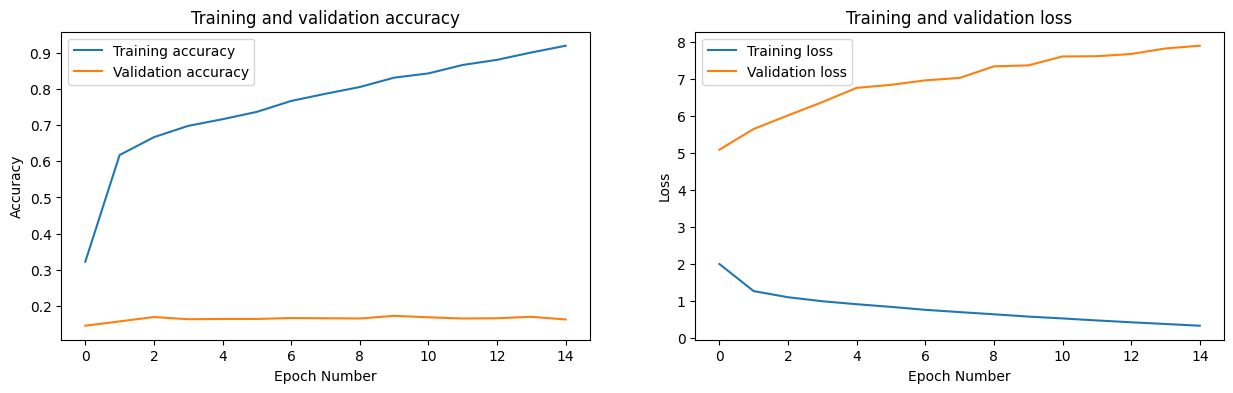

In [22]:
m.model_train(image_model_13, X_train, Y_train, 15)

In [34]:
X_test = image_features(X_test)
X_test=np.asarray(X_test).astype(np.float32)
Y_test=np.asarray(Y_test).astype(np.int32)

In [24]:
m.model_evaluate(image_model_13, X_test, Y_test)

9/9 [==============================] - 2s 238ms/step - loss: 1.9916 - accuracy: 0.7115
[1.9915781021118164, 0.7115384340286255]


52 classes

In [35]:
Y_train = image_set[image_set["data set"]=="train"]
Y_train = Y_train["class index"]

Y_train=np.asarray(Y_train).astype(np.int32)

In [36]:
Y_test = image_set[image_set["data set"]=="test"]
Y_test = Y_test["class index"]

Y_test=np.asarray(Y_test).astype(np.int32)

In [26]:
image_model_52 = m.model_create_image_52()
m.model_compile(image_model_52)
image_model_52.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 19, 32)      

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

Epoch 1/15
165/165 [==============================] - ETA: 0s - loss: 3.6482 - accuracy: 0.0323
Epoch 1: accuracy improved from -inf to 0.03234, saving model to model.h5
165/165 [==============================] - 342s 2s/step - loss: 3.6482 - accuracy: 0.0323 - val_loss: 8.1570 - val_accuracy: 0.0000e+00
Epoch 2/15
165/165 [==============================] - ETA: 0s - loss: 3.0217 - accuracy: 0.1682
Epoch 2: accuracy improved from 0.03234 to 0.16819, saving model to model.h5
165/165 [==============================] - 331s 2s/step - loss: 3.0217 - accuracy: 0.1682 - val_loss: 8.3109 - val_accuracy: 0.0000e+00
Epoch 3/15
165/165 [==============================] - ETA: 0s - loss: 2.4109 - accuracy: 0.3293
Epoch 3: accuracy improved from 0.16819 to 0.32934, saving model to model.h5
165/165 [==============================] - 333s 2s/step - loss: 2.4109 - accuracy: 0.3293 - val_loss: 9.0566 - val_accuracy: 0.0000e+00
Epoch 4/15
165/165 [==============================] - ETA: 0s - loss: 2.0968

<Figure size 1500x400 with 0 Axes>

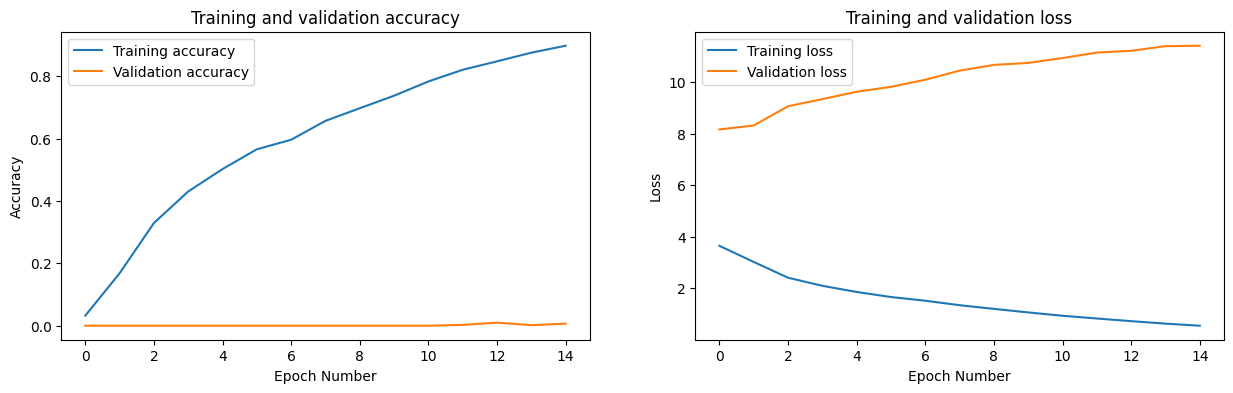

In [28]:
m.model_train_im52(image_model_52, X_train, Y_train, 15, callbacks)

In [38]:
m.model_evaluate(image_model_52, X_test, Y_test)

9/9 [==============================] - 4s 406ms/step - loss: 4.2338 - accuracy: 0.5115
[4.233750343322754, 0.5115384459495544]


3. Text classification

In [ ]:
#text = load_unprocessed_text_to_df()
#text = clean_text(text)
#text = lemmatize_text(text)
#text.to_csv(lenta-ru-clean-20k.csv)

In [83]:
text = load_processed_text_to_df()
text.head()

Unnamed: 0                                               text  topic_label
0           0  инфляция январь 2006 год составить 2 6 процент...            0
1           1  никита михалков учредить день российский киноу...            3
2           2  марко матерацци вернуться строй матч цскамедиц...            1
3           3  определить лауреат премия  книга год премия  к...            3
4           4  гол роналда штрафной спасти португалец поражен...            1

In [84]:
x = tokenize_text(text, 750)
y = text["topic_label"]

In [95]:
text_model = m.model_create_text()
m.model_compile(text_model)
text_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 750, 64)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 673,349
Trainable params: 673,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#text_model = m.model_load("text", "saved_model\\")
#text_model.summary()

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.5, random_state = 0)

Epoch 1/4
250/250 [==============================] - 135s 529ms/step - loss: 0.8751 - accuracy: 0.6733 - val_loss: 0.3251 - val_accuracy: 0.9225
Epoch 2/4
250/250 [==============================] - 129s 517ms/step - loss: 0.2596 - accuracy: 0.9325 - val_loss: 0.2449 - val_accuracy: 0.9335
Epoch 3/4
250/250 [==============================] - 131s 524ms/step - loss: 0.1744 - accuracy: 0.9516 - val_loss: 0.2863 - val_accuracy: 0.9190
Epoch 4/4
250/250 [==============================] - 146s 586ms/step - loss: 0.0988 - accuracy: 0.9704 - val_loss: 0.2296 - val_accuracy: 0.9380


<Figure size 1500x400 with 0 Axes>

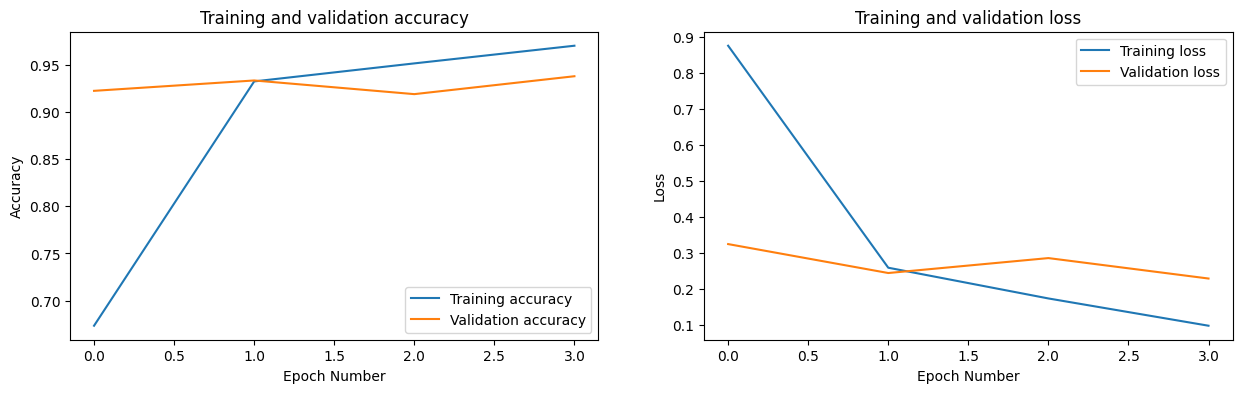

In [96]:
m.model_train(text_model, X_train, Y_train, 4)

In [97]:
m.model_evaluate(text_model, X_test, Y_test)

313/313 [==============================] - 54s 171ms/step - loss: 0.2327 - accuracy: 0.9370
[0.23269040882587433, 0.9369999766349792]


In [116]:
text_model2 = m.model_create_text_2()
m.model_compile(text_model2)
text_model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 750, 64)           640000    
                                                                 
 lstm_8 (LSTM)               (None, 750, 64)           33024     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                                                 
Total params: 706,373
Trainable params: 706,373
Non-trainable params: 0
_________________________________________________________________


Epoch 1/4
250/250 [==============================] - 376s 1s/step - loss: 0.6584 - accuracy: 0.7579 - val_loss: 0.3446 - val_accuracy: 0.9005
Epoch 2/4
250/250 [==============================] - 375s 2s/step - loss: 0.2185 - accuracy: 0.9383 - val_loss: 0.2557 - val_accuracy: 0.9255
Epoch 3/4
250/250 [==============================] - 334s 1s/step - loss: 0.1285 - accuracy: 0.9629 - val_loss: 0.2873 - val_accuracy: 0.9275
Epoch 4/4
250/250 [==============================] - 344s 1s/step - loss: 0.0972 - accuracy: 0.9716 - val_loss: 0.2489 - val_accuracy: 0.9210


<Figure size 1500x400 with 0 Axes>

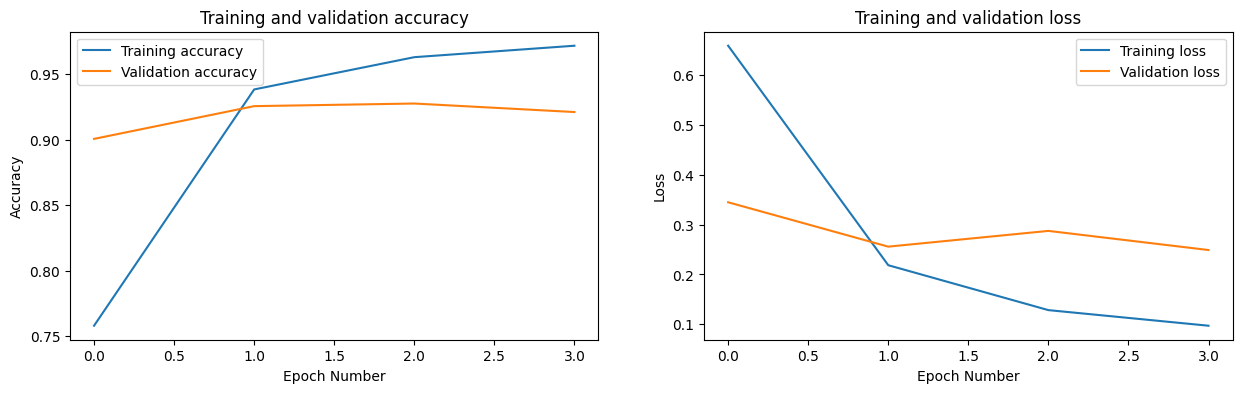

In [117]:
m.model_train(text_model2, X_train, Y_train, 4)

In [120]:
m.model_evaluate(text_model2, X_test, Y_test)

313/313 [==============================] - 137s 438ms/step - loss: 0.2501 - accuracy: 0.9257
[0.25006529688835144, 0.9257000088691711]


drink dataset: https://www.kaggle.com/heitornunes/caffeine-content-of-drinks

ru text dataset: https://www.kaggle.com/c/lenta-ru-ozon-2020

image dataset: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification